# HW03 – 品牌關鍵詞分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import re

# font
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


## 定義品牌

In [2]:
from typing import TypedDict


class BrandMatcher(TypedDict):
    brand: str
    matcher: re.Pattern


In [3]:
brands_matchers: list[BrandMatcher] = [
    {
        "brand": "Nike",
        "matcher": re.compile(r"Nike|耐吉|耐克", re.IGNORECASE)
    },
    {
        "brand": "Shock Absorber",
        "matcher": re.compile(r"Shock(?:\s*)Absorber|Shock_Absorber|SA", re.IGNORECASE)
    },
    {
        "brand": "Adidas",
        "matcher": re.compile(r"Adidas|愛迪達|addias", re.IGNORECASE)
    },
    {
        "brand": "UA",
        "matcher": re.compile(r"UA|Under Armour", re.IGNORECASE)
    },
    {
        "brand": "Triumph",
        "matcher": re.compile(r"Triumph|黛安芬", re.IGNORECASE)
    },
    {
        "brand": "Decathlon",
        "matcher": re.compile(r"Decathlon|迪卡[儂農]", re.IGNORECASE)
    },
    {
        "brand": "Mollifix",
        "matcher": re.compile(r"Mollifix", re.IGNORECASE)
    },
    {
        "brand": "Uniqio",
        "matcher": re.compile(r"Uniqio", re.IGNORECASE)
    },
    {
        "brand": "Calvin Klein",
        "matcher": re.compile(r"Calvin(.*)Klein|CK|Calvin_Klein", re.IGNORECASE)
    }
]

## Import file

In [4]:
df = pd.read_csv('PTT_運動內衣_所有資料1000.csv')

移除「公告」分類的項目

In [5]:
df = df[df['分類'] != '公告']

## 合併標題、內文變所有文

讀取 stopwords list

In [6]:
# stopwords and remove_words cleaning
import json


with open("stopwords.txt", "r") as f:
    stopwords = f.read().splitlines()

with open("remove_words.json", "r") as f:
    stopwords.extend(json.load(f))

In [7]:
df = df.replace(stopwords, '')

In [8]:
from typing import Any

COMFORTABLE_REGEX = re.compile('舒服|好穿|舒適')

# 清理文字中的 stopwords 和垃圾文字
def clean_stopwords(x: Any) -> str:
    x = str(x)

    # 移除 html tags
    x = re.sub(r'<[^>]*>', '', x)

    # 移除網址
    x = re.sub(r'https?://[^\s]+', '', x)

    # 移除非必要前綴
    x = re.sub(r'(新聞連結|原文連結|原文內容)[：:]', '', x)
    
    # 移除空白
    x = re.sub(r'\s*', '', x)

    # 移除停用詞
    for word in stopwords:
        x = x.replace(word, '')

    # 統一字眼
    x = COMFORTABLE_REGEX.sub('舒適', x)

    return x

df['所有文'] = (df['標題'] + "\n" + df['內文']).apply(clean_stopwords)

## 整合各品牌不一致的稱謂

In [9]:
def unify_brand_words(x: str) -> str:
    for brand_matcher in brands_matchers:
        matcher = brand_matcher['matcher']
        x = matcher.sub(brand_matcher['brand'], x)

    return x

df['所有文'] = df['所有文'].apply(unify_brand_words)

## 根據品牌分類文章

同時，移除和品牌無關的貼文

In [10]:
def brand_category(x: str) -> str | None:
    for brand_matcher in brands_matchers:
        matcher = brand_matcher['matcher']
        if matcher.search(x):
            return brand_matcher['brand']
    return None

df['品牌'] = df['所有文'].apply(brand_category)
df.dropna(subset=['品牌'], inplace=True)

## 畫出各品牌各關鍵字長條圖（一個品牌一張圖）

In [11]:
import jieba.analyse


In [12]:
# 探勘這些文章中最常出現的幾個關鍵字

tfidf = jieba.analyse.extract_tags(" ".join(df['所有文']), topK=250, withWeight=True)
tfidf_df = pd.DataFrame(tfidf, columns=['關鍵字', 'TF-IDF'])
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

tfidf_df.head(20)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/qj/62r8d09n5hn3nm_bdzf0dcpr0000gn/T/jieba.cache
Loading model cost 0.305 seconds.
Prefix dict has been built successfully.


,關鍵字,TF-IDF
0,Klein,0.059687
1,問題,0.055542
2,運動,0.037304
3,感覺,0.028185
4,飲食,0.025698
5,訓練,0.024869
6,大卡,0.024537
8,活動,0.024041
7,發現,0.024041
9,身體,0.023212


使用 ChatGPT 從 TF-IDF 中拉出有意義的關鍵詞

https://chatgpt.com/share/680fac59-87b0-8013-be46-d101aea2d310

In [13]:
sports_bra_keywords = [
    "運動",
    "訓練",
    "跑步",
    "活動",
    "舒適",
    "吸汗",
    "尺寸",
    "材質",
    "支撐",
    "健身房",
    "骨盆",
    "脊椎",
    "重心",
    "背心",
    "姿勢",
    "核心"
]

根據 keywords 畫出各品牌各關鍵字長條圖

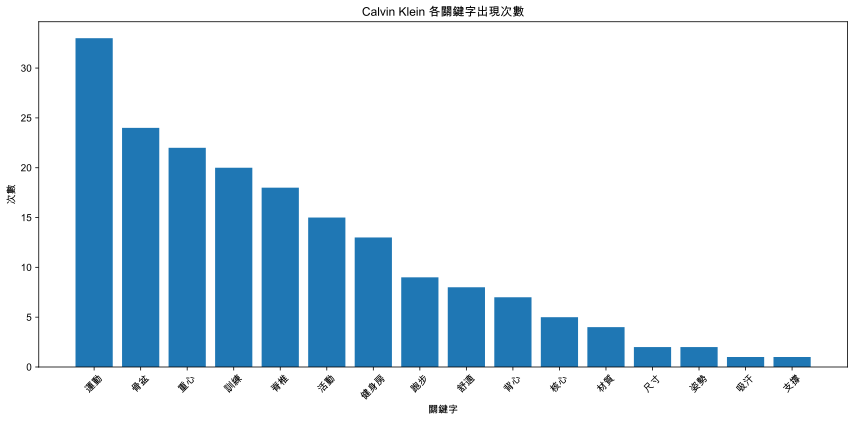

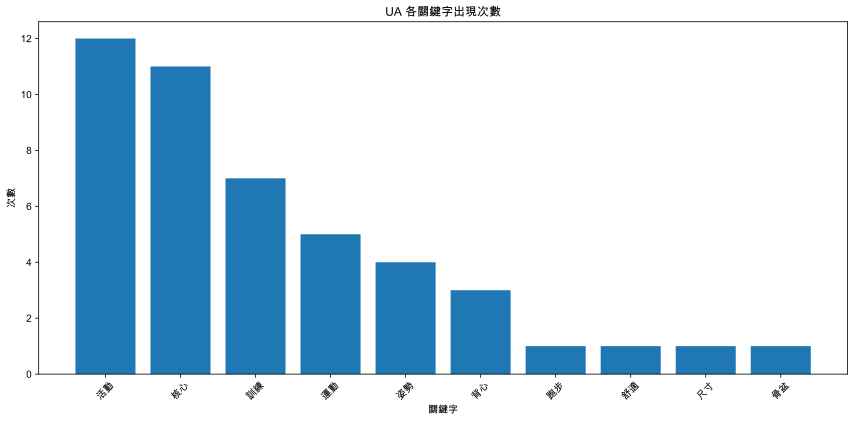

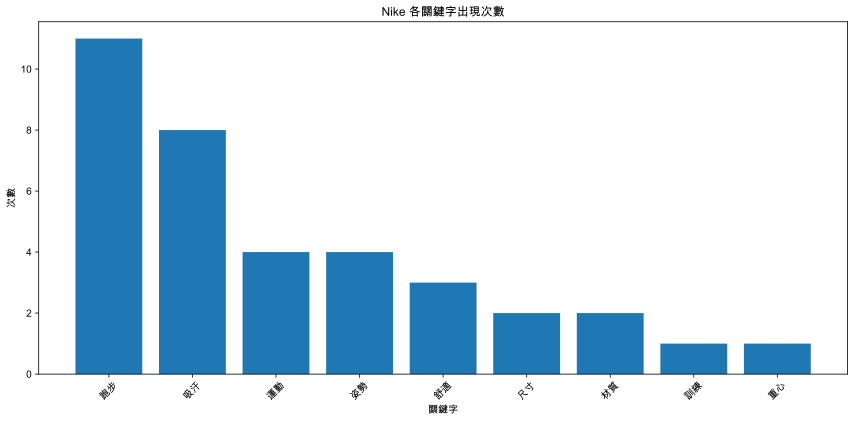

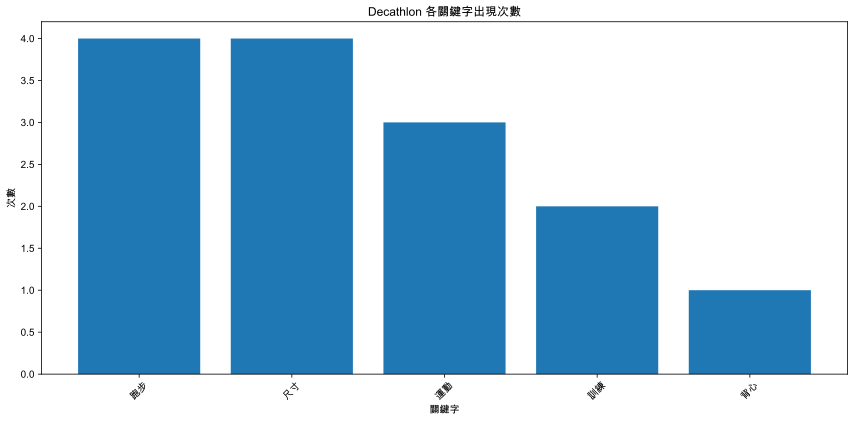

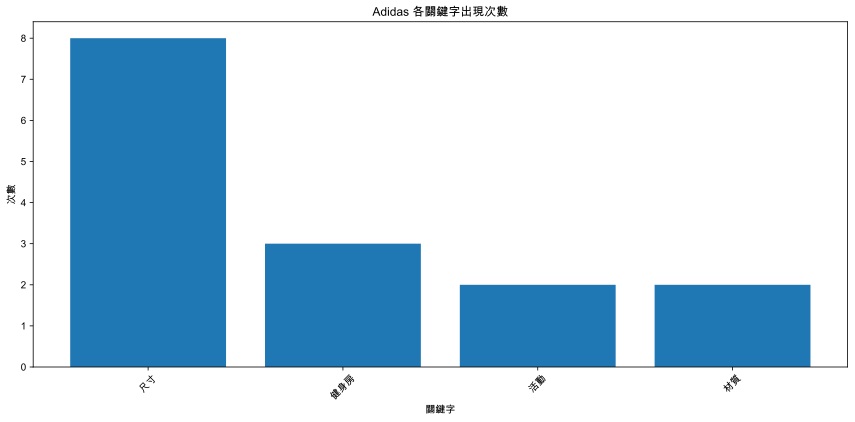

In [14]:
from collections import Counter


# 根據品牌，彙整成一個大的「所有文」
brand_article_df = {}
for brand in df['品牌'].unique():
    brand_df = df[df['品牌'] == brand]
    text = " ".join(brand_df['所有文'])

    # jieba 斷詞
    words = jieba.cut(text)
    # 統計關鍵字出現次數
    word_counter = Counter(words)
    keyword_counts = {kw: word_counter.get(kw, 0) for kw in sports_bra_keywords}

    # 如果沒有 keywords 出現，則提醒並不寫入
    if not any(keyword_counts.values()):
        print(f"品牌 {brand} 沒有關鍵字出現")
        continue

    # 寫入 brand_article_df
    brand_article_df[brand] = keyword_counts

# 畫出各品牌各關鍵字長條圖
for brand, keyword_counts in brand_article_df.items():
    drawing_df = pd.DataFrame(list(keyword_counts.items()), columns=['關鍵字', '次數'])
    drawing_df = drawing_df[drawing_df['次數'] > 0]  # 只顯示有出現的關鍵字
    drawing_df = drawing_df.sort_values(by='次數', ascending=False)
    # 畫圖
    plt.figure(figsize=(12, 6))
    plt.bar(drawing_df['關鍵字'], drawing_df['次數'])
    plt.title(f"{brand} 各關鍵字出現次數")
    plt.xlabel("關鍵字")
    plt.ylabel("次數")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 整合比較圖(一張圖)：橫向堆疊長條圖（stacked bar chart），比較所有品牌在各關鍵字的表現

<Figure size 1200x600 with 0 Axes>

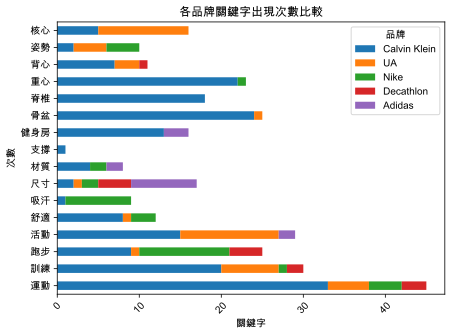

In [15]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 根據品牌，彙整成一個大的「所有文」
brand_article_df = {}
for brand in df['品牌'].unique():
    brand_df = df[df['品牌'] == brand]
    text = " ".join(brand_df['所有文'])

    # jieba 斷詞
    words = jieba.cut(text)
    # 統計關鍵字出現次數
    word_counter = Counter(words)
    keyword_counts = {kw: word_counter.get(kw, 0) for kw in sports_bra_keywords}

    # 如果沒有 keywords 出現，則提醒並不寫入
    if not any(keyword_counts.values()):
        print(f"品牌 {brand} 沒有關鍵字出現")
        continue

    # 寫入 brand_article_df
    brand_article_df[brand] = keyword_counts

# 將資料轉換為適合繪製堆疊長條圖的格式
plot_data = pd.DataFrame(brand_article_df).fillna(0)

# 去掉沒有關鍵字的
plot_data = plot_data[plot_data.sum(axis=1) > 0]

# 畫出堆疊長條圖
plt.figure(figsize=(12, 6))

assert isinstance(plot_data, pd.DataFrame)
plot_data.plot(kind='barh', stacked=True)
plt.title('各品牌關鍵字出現次數比較')
plt.xlabel('關鍵字')
plt.ylabel('次數')
plt.legend(title='品牌')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 將品牌 × 關鍵字頻率表儲存成 CSV 檔案（檔名：brand_keyword.csv），並且不要有亂碼

In [16]:
# Save brand_keyword frequency table as CSV
plot_data.to_csv('brand_keyword.csv', encoding='utf-8-sig')